In [161]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import data, util, transform, feature, measure, filters, metrics
from PIL import Image
from skimage.filters import difference_of_gaussians

In [162]:
# parameter setting
denominate_faction =3.5  # using (1/deno_faction) portion of extracted points to match
min_dist = 5
direction = "V" # 

harris_detector = False
hessian_detector = False
DoG_detector = True

# print setting
show_keypoints_extract_infor = False
show_match_points_infor = True
show_iterative_result = True

# exclude invalid setting
if direction != "V" and direction != "H": 
    raise AssertionError("[error] stitch direction setting wrong")
if harris_detector+hessian_detector+DoG_detector !=1 : 
    raise AssertionError("[error] detector setting wrong") 

In [163]:
# ref: https://scikit-image.org/docs/dev/auto_examples/registration/plot_stitching.html

def match_locations(img0, img1, coords0, coords1, radius=5, sigma=3):
    """Match image locations using SSD minimization.

    Areas from `img0` are matched with areas from `img1`. These areas
    are defined as patches located around pixels with Gaussian
    weights.

    Parameters:
    -----------
    img0, img1 : 2D array
        Input images.
    coords0 : (2, m) array_like
        Centers of the reference patches in `img0`.
    coords1 : (2, n) array_like
        Centers of the candidate patches in `img1`.
    radius : int
        Radius of the considered patches.
    sigma : float
        Standard deviation of the Gaussian kernel centered over the patches.

    Returns:
    --------
    match_coords: (2, m) array
        The points in `coords1` that are the closest corresponding matches to
        those in `coords0` as determined by the (Gaussian weighted) sum of
        squared differences between patches surrounding each point.
    """
    y, x = np.mgrid[-radius:radius + 1, -radius:radius + 1]
    weights = np.exp(-0.5 * (x ** 2 + y ** 2) / sigma ** 2)
    weights /= 2 * np.pi * sigma * sigma

    match_list = []
    for r0, c0 in coords0:
        roi0 = img0[r0 - radius:r0 + radius + 1, c0 - radius:c0 + radius + 1]
        roi1_list = [img1[r1 - radius:r1 + radius + 1,c1 - radius:c1 + radius + 1] for r1, c1 in coords1]
        # sum of squared differences
        ssd_list = [np.sum(weights * (roi0 - roi1) ** 2) for roi1 in roi1_list]
        match_list.append(coords1[np.argmin(ssd_list)])

    return np.array(match_list)

In [164]:
# self-develope function

def stitched_img(img_ref,img_added,ref_pt,pt,stitch_dir):
    # cauculate diff and cauculate the offset which is used in stitch process
    
    if stitch_dir == "H":
        # horizontally
        width = img_added.shape[1] 
        final_offset = img_ref.shape[1] 
        offset_bound = img_ref.shape[1] 
    
    if stitch_dir == "V":
        # vertically
        width = img_added.shape[0] 
        final_offset = img_ref.shape[0] 
        offset_bound = img_ref.shape[0] 
    
    diff= float("inf")
    offset = 0 # from 0 to offset_bound 
    
    
    while offset <= offset_bound:
        tem_diff = 0
        
        for i in range (len(ref_pt)-2):
            if stitch_dir == "H":
                # horizontally
                point_diff = float("inf")
                for j in range(len(ref_pt)):
                    point_diff = min(point_diff, int( abs(ref_pt[i][0] - (pt[j][0])) +abs(ref_pt[i][1] - (pt[j][1]- width+offset)) ) )
                tem_diff += point_diff
            
            if stitch_dir == "V":
                # vertically 
                point_diff = float("inf")
                for j in range(len(ref_pt)):
                    point_diff = min(point_diff, int( abs(ref_pt[i][0] - (pt[j][0]- width+offset)) +abs(ref_pt[i][1] - (pt[j][1])) ) ) 
                tem_diff += point_diff
            

        # capture the global min
        if tem_diff<diff:
            diff = tem_diff
            final_offset = offset
            
        offset += 1
    
    
    
    # stitched image
    if stitch_dir == "H":
        # horizontal stitch
        output_img = np.zeros([max(img_ref.shape[0],img_added.shape[0]),img_ref.shape[1]+img_added.shape[1]-final_offset] ,dtype=np.uint16)   
        output_img[0:img_added.shape[0],0:img_added.shape[1]]=img_added
        output_img[0:img_ref.shape[0],img_added.shape[1]:] = img_ref[0:img_ref.shape[0],final_offset:img_ref.shape[1]]
    
    if stitch_dir == "V":
        # vertical stitch
        output_img = np.zeros([img_ref.shape[0]+img_added.shape[0]-final_offset,max(img_ref.shape[1],img_added.shape[1])] ,dtype=np.uint16)   
        output_img[0:img_added.shape[0],0:img_added.shape[1]]=img_added
        output_img[img_added.shape[0]:,0:img_ref.shape[1]] = img_ref[final_offset:img_ref.shape[1],0:img_ref.shape[1]]
    
    return output_img
    

In [165]:
# Open the image form working directory
img_list = []

if direction == "H":
    # horizontal
    path1 = './imagedata/horizontal_25/image_i0_j4.tif'
    path2 = './imagedata/horizontal_25/image_i1_j4.tif'
    path3 = './imagedata/horizontal_25/image_i2_j4.tif'
    path4 = './imagedata/horizontal_25/image_i3_j4.tif'
    path5 = './imagedata/horizontal_25/image_i4_j4.tif'   
if direction == "V":    
    # vertical
    path1 = './imagedata/horizontal_25/image_i0_j0.tif'
    path2 = './imagedata/horizontal_25/image_i0_j1.tif'
    path3 = './imagedata/horizontal_25/image_i0_j2.tif'
    path4 = './imagedata/horizontal_25/image_i0_j3.tif'
    path5 = './imagedata/horizontal_25/image_i0_j4.tif'

image = Image.open(path1)
img = np.array(image)
img_list.append(img)
image = Image.open(path2)
img = np.array(image)
img_list.append(img)
image = Image.open(path3)
img = np.array(image)
img_list.append(img)
image = Image.open(path4)
img = np.array(image)
img_list.append(img)
image = Image.open(path5)
img = np.array(image)
img_list.append(img)

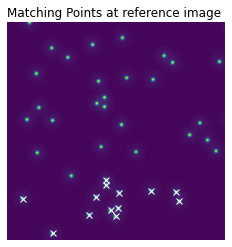

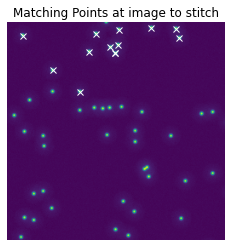

iterative stitch image dimension :  (448, 256)


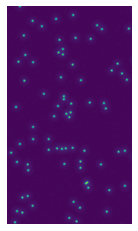

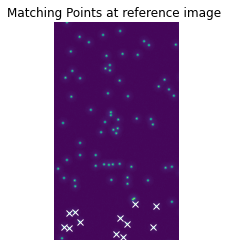

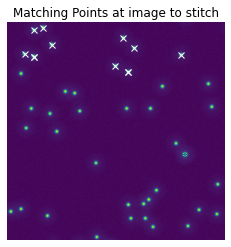

iterative stitch image dimension :  (640, 256)


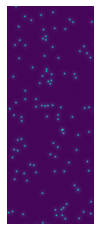

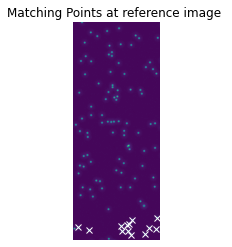

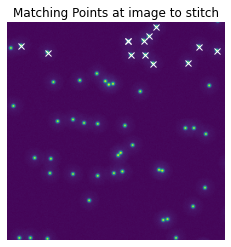

iterative stitch image dimension :  (832, 256)


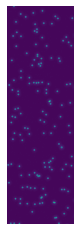

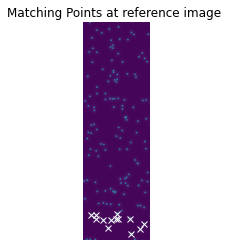

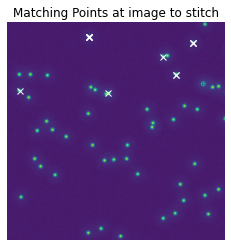

iterative stitch image dimension :  (1024, 256)


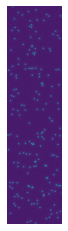

In [166]:
# main program
# stitch the image iterativly

while(len(img_list)>=2):
    
    corner_list = []
    for i in range(0,2,1):
        if harris_detector:
            corner_list.append(feature.corner_peaks(feature.corner_harris(img_list[i]), threshold_rel=0.001, min_distance=min_dist))
        if hessian_detector:
            corner_list.append(feature.corner_peaks(feature.hessian_matrix_det(img_list[i]), threshold_rel=0.2, min_distance=min_dist))
        if DoG_detector:
            corner_list.append(feature.corner_peaks(difference_of_gaussians(image=img_list[i],low_sigma=2, high_sigma=2.6), threshold_rel=0.6, min_distance=min_dist))

    
    if direction == "H":
        # horizontally
        corner_list[0] = sorted(corner_list[0],key=lambda s:s[1], reverse=True )  # corner_list[0][0][0] :y
                                                                 # corner_list[0][0][1] :x
        corner_list[1] = sorted(corner_list[1],key=lambda s:s[1])
    
    if direction == "V":
        # vertically
        corner_list[0] = sorted(corner_list[0],key=lambda s:s[0], reverse=True )  # corner_list[0][0][0] :y
                                                                 # corner_list[0][0][1] :x
        corner_list[1] = sorted(corner_list[1],key=lambda s:s[0])


    fraction = int(len(corner_list[1])/denominate_faction)+1
    
    
    img0 = img_list[0]
    coords0 = corner_list[0][0:fraction]

    matching_corners=[]
    for i in range(0,2,1):
        matching_corners.append(match_locations(img0, img_list[i], coords0, corner_list[i][0:fraction], min_dist))

    
    
    # show the match points
    if show_keypoints_extract_infor and show_iterative_result:
        # r : Harris Detector
        # y : Hessian Detector
        # w : Difference of Gaussians (DoG)
        
        # OPTIONAL: help understand
        fig5, ax5 = plt.subplots()
        ax5.imshow(img_list[0])
        for i in range(fraction):
            plt.plot(corner_list[0][i][1],corner_list[0][i][0],"xw")
            plt.title("keypoints_extract : Difference of Gaussians (DoG)")
        plt.axis("off")
        plt.show()

        fig6, ax6 = plt.subplots()
        ax6.imshow(img_list[1])
        for i in range(fraction):
            plt.plot(corner_list[1][i][1],corner_list[1][i][0],"xw")
            plt.title("keypoints_extract : Difference of Gaussians (DoG)")
        plt.axis("off")
        plt.show()
    
    if show_match_points_infor and show_iterative_result:
        fig7, ax7 = plt.subplots()
        ax7.imshow(img_list[0])
        for i in range(fraction):
            plt.plot(matching_corners[0][i][1],matching_corners[0][i][0],"xw")
            plt.title("Matching Points at reference image ")
        plt.axis("off")
        plt.show()

        fig8, ax8 = plt.subplots()
        ax8.imshow(img_list[1])
        for i in range(fraction):
            plt.plot(matching_corners[1][i][1],matching_corners[1][i][0],"xw")
            plt.title("Matching Points at image to stitch")
        plt.axis("off")
        plt.show()
    
    
    
    # call self-develope function to stitch image
    sti = stitched_img(img_list[1],img_list[0],matching_corners[1],matching_corners[0],direction)
    if show_iterative_result:
        print("iterative stitch image dimension : ",sti.shape)
        plt.imshow(sti)
        plt.axis("off")
        plt.show()
        
    
    
    img_list[1] = sti
    # pop the image which has been merged into iterative stitch image
    img_list.pop(0)

    

stitch image dimension :  (1024, 256)


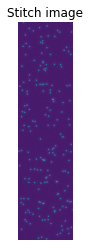

In [167]:
# main program
# show the fianl stitching result

plt.imshow(sti)
print("stitch image dimension : ",sti.shape)
plt.title("Stitch image")
plt.axis("off")
plt.show()